In [1]:
from hpcom.signal import create_wdm_parameters, generate_wdm
from hpcom.channel import create_channel_parameters

from ssfm_gpu.propagation import propagate_manakov, propagate_schrodinger
from ssfm_gpu.conversion import convert_forward, convert_inverse

from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# from importlib import reload
# reload(ssfm_gpu)

2022-12-14 12:04:01.166903: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [6]:

# create parameters
wdm_one_pol = create_wdm_parameters(n_channels=1, p_ave_dbm=10, n_symbols=2 ** 16, m_order=16, roll_off=0.1, upsampling=16,
                                     downsampling_rate=1, symb_freq=34e9, channel_spacing=75e9, n_polarisations=1)
wdm_two_pols = wdm_one_pol.copy()
wdm_two_pols['n_polarisations'] = 2

channel_dimension = create_channel_parameters(n_spans=1,
                                              z_span=80,
                                              alpha_db=0.,
                                              gamma=1.2,
                                              noise_figure_db=-200,
                                              dispersion_parameter=16.8,
                                              dz=1)

In [7]:
# NLSE - one polarisation
signal, wdm_info = generate_wdm(wdm_one_pol)

dt_dim = 1. / wdm_one_pol['sample_freq']
t_dim = np.arange(len(signal)) * dt_dim

convert_result = ssfm_gpu.conversion.convert_inverse(signal, t_dim, channel_dimension['z_span'],
                                 channel_dimension['beta2'],
                                 channel_dimension['gamma'],
                                 t0=1. / wdm_one_pol['symb_freq'], type='nlse')

q = convert_result['q']
t = convert_result['t']
dt = t[0] - t[1]
z_span_dimless = convert_result['z']
print(channel_dimension['z_span'], z_span_dimless)

channel_dimensionless = channel_dimension.copy()
channel_dimensionless['beta2'] = -1.
channel_dimensionless['gamma'] = 1.
channel_dimensionless['z_span'] = z_span_dimless
# channel_dimensionless['nz'] = 800

start_time = datetime.now()
signal_prop = propagate_schrodinger(channel_dimension, signal, sample_freq=int(wdm_one_pol['symb_freq'] * wdm_one_pol['upsampling']))
print("propagation took", (datetime.now() - start_time).total_seconds() * 1000, "ms")

start_time = datetime.now()
q_prop = propagate_schrodinger(channel_dimension, q, sample_freq=1./dt)
print("propagation took", (datetime.now() - start_time).total_seconds() * 1000, "ms")

convert_forward_result = convert_forward(q_prop, t, channel_dimensionless['z_span'],
                                         channel_dimension['beta2'],
                                         channel_dimension['gamma'],
                                         t0=1. / wdm_one_pol['symb_freq'], type='nlse')

signal_from_q_prop = convert_forward_result['Q']


filter_values_mean (1.525878905866743e-05+0j)
Signal generation took 309.076 ms
80 1.9802470549106115
propagation took 3405.8250000000003 ms
propagation took 3537.175 ms


(0.0, 3.764705882352941e-09)

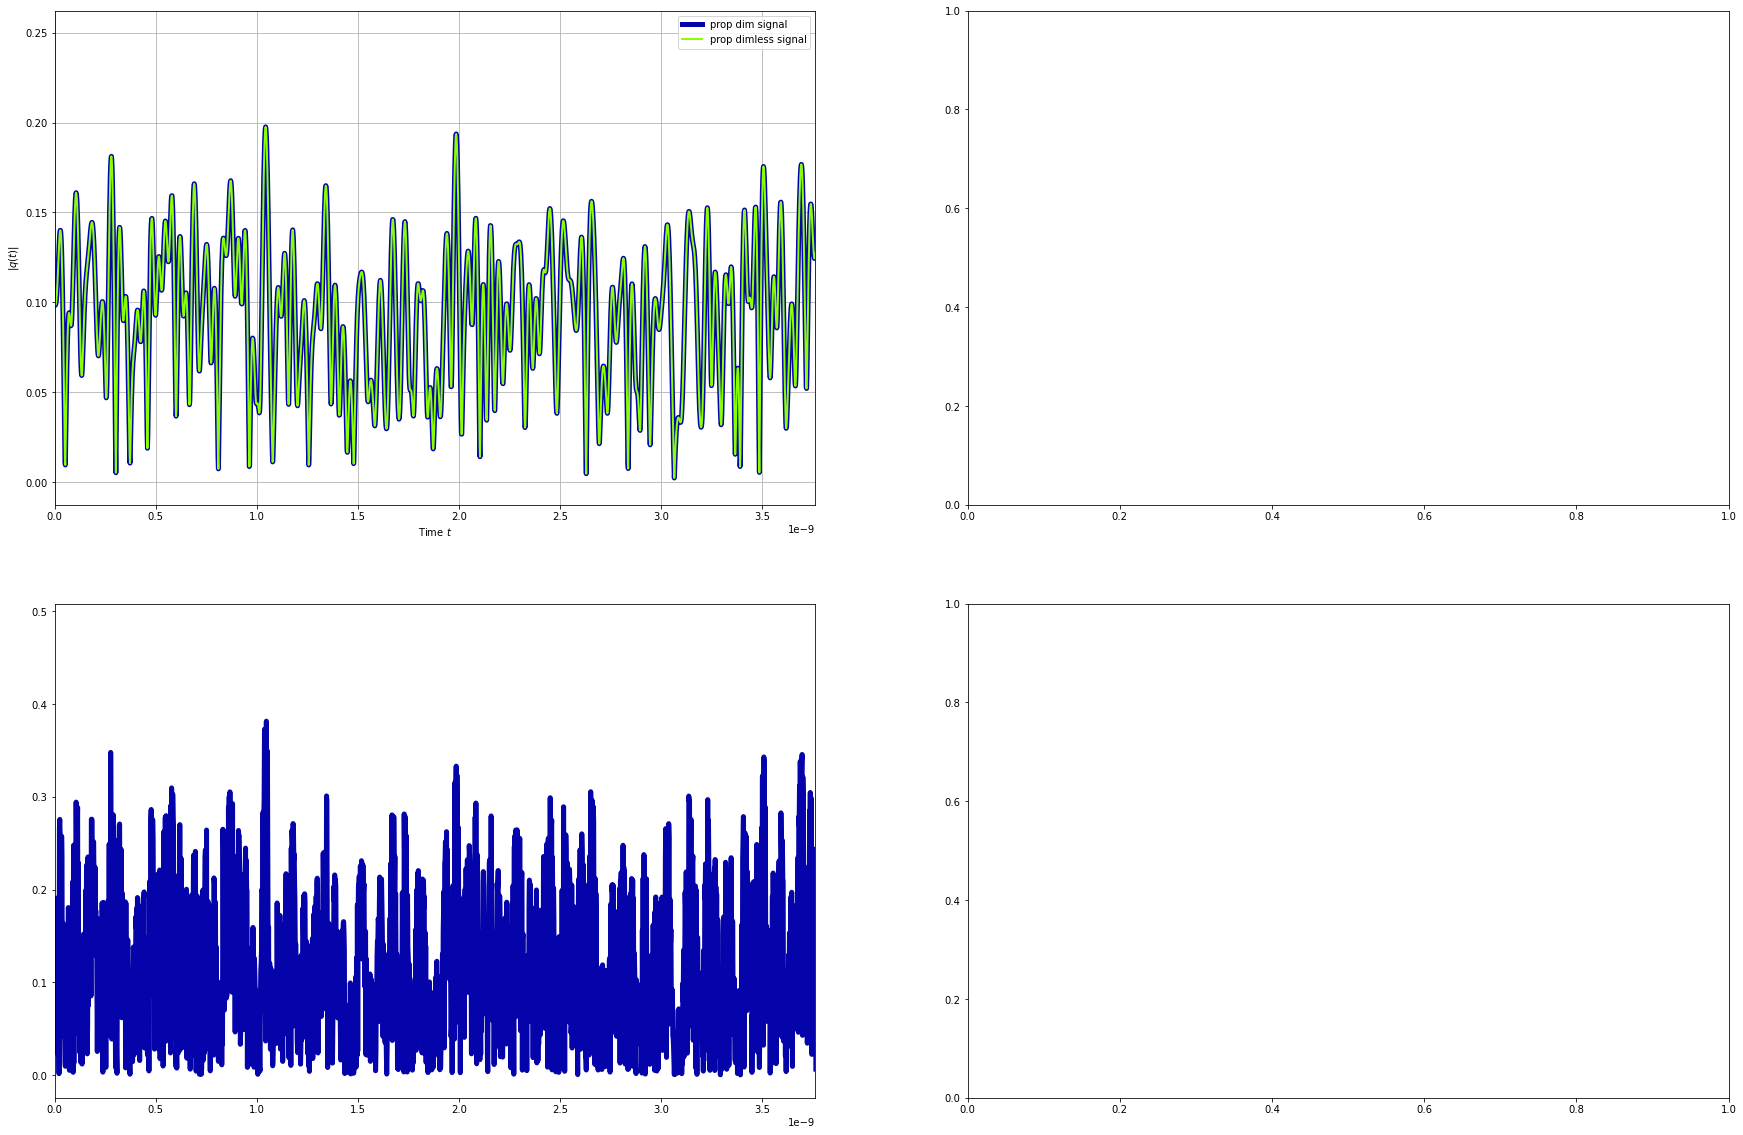

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(30,20))
axs[0][0].plot(t_dim, np.absolute(signal),
               color='xkcd:royal blue', linewidth=5,
               label='prop dim signal')
axs[0][0].plot(t_dim, np.absolute(signal_from_q_prop),
               color='xkcd:lime green', linewidth=2,
               label='prop dimless signal')
axs[0][0].set_xlabel('Time $t$')
axs[0][0].set_xlim(t_dim[0], t_dim[2048])
# axs[0][0].set_xlim(-t_plot_full_lim, t_plot_full_lim)
axs[0][0].set_ylabel(r'$|q(t)|$')
axs[0][0].legend()
axs[0][0].grid(True)

axs[1][0].plot(t_dim, np.absolute(signal),
               color='xkcd:royal blue', linewidth=5,
               label='prop dim signal')
axs[1][0].set_xlim(t_dim[0], t_dim[2048])


In [45]:
# Manakov - two polarisations
signal_x, signal_y, wdm_info = generate_wdm(wdm_two_pols)

dt_dim = 1. / wdm_two_pols['sample_freq']
t_dim = np.arange(len(signal_x)) * dt_dim

convert_result = convert_inverse((signal_x, signal_y), t_dim, channel_dimension['z_span'],
                                 channel_dimension['beta2'],
                                 channel_dimension['gamma'],
                                 t0=1. / wdm_two_pols['symb_freq'], type='manakov')

q_x = convert_result['q1']
q_y = convert_result['q2']
t = convert_result['t']
dt = t[0] - t[1]
z_span_dimless = convert_result['z']
print(channel_dimension['z_span'], z_span_dimless)

channel_dimensionless = channel_dimension.copy()
channel_dimensionless['beta2'] = -2.
channel_dimensionless['gamma'] = 2 * 9./8.
channel_dimensionless['z_span'] = z_span_dimless
channel_dimensionless['nz'] = 800

start_time = datetime.now()
signal_x_prop, signal_y_prop = propagate_manakov(channel_dimension, signal_x, signal_y,
                                                 sample_freq=int(wdm_two_pols['symb_freq'] * wdm_two_pols['upsampling']))
print("propagation took", (datetime.now() - start_time).total_seconds() * 1000, "ms")

start_time = datetime.now()
q_x_prop, q_y_prop = propagate_manakov(channel_dimensionless, q_x, q_y,
                                       sample_freq=1./dt)
print("propagation took", (datetime.now() - start_time).total_seconds() * 1000, "ms")

convert_forward_result = convert_forward((q_x_prop, q_y_prop), t, channel_dimensionless['z_span'],
                                         channel_dimension['beta2'],
                                         channel_dimension['gamma'],
                                         t0=1. / wdm_two_pols['symb_freq'], type='manakov')

signal_from_q_x_prop = convert_forward_result['Q1']
signal_from_q_y_prop = convert_forward_result['Q2']

filter_values_mean (1.525878905866743e-05+0j)
filter_values_mean (1.525878905866743e-05+0j)
Signal generation took 490.81399999999996 ms
80 0.9901235274553057
propagation took 552.3169999999999 ms
propagation took 5593.17 ms


In [30]:
for key, _ in channel_dimension.items():
    print(key, channel_dimension[key], channel_dimensionless[key])



n_spans 10 10
z_span 80 0.9901235274553057
alpha_db 0.0 0.0
alpha 0.0 0.0
gamma 0.001 2.25
noise_figure_db -200 -200
noise_figure 1e-20 1e-20
gain 1.0 1.0
dispersion_parameter 16.8 16.8
beta2 -2.1412706043583603e-23 -2.0
beta3 0 0
h_planck 6.6256e-34 6.6256e-34
fc 6.6256e-34 6.6256e-34
dz 0.1 0.1
nz 800 800
noise_density 0.0 0.0
seed fixed fixed


In [13]:
print(np.mean(np.absolute(q_x)))
print(np.mean(np.absolute(q_x_prop)))


0.009611058762332885
0.009237299038862912


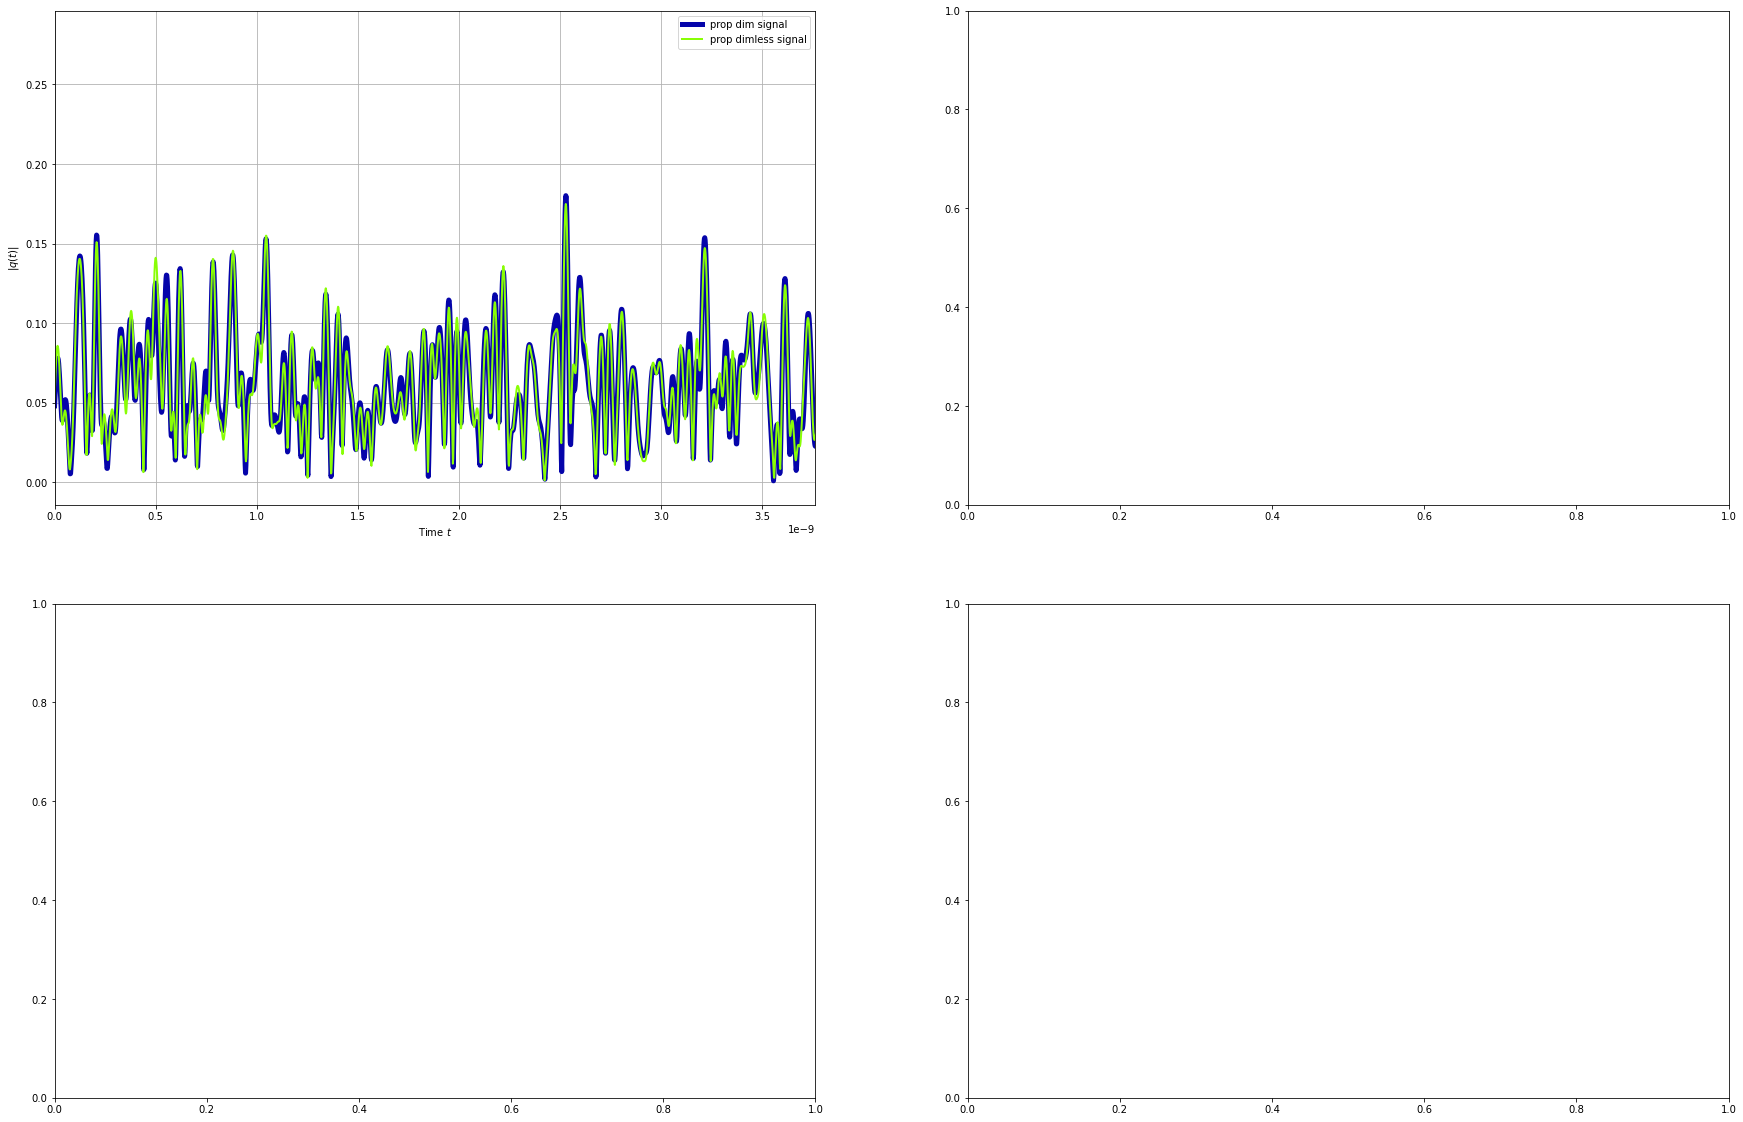

In [46]:


fig, axs = plt.subplots(2, 2, figsize=(30,20))
axs[0][0].plot(t_dim, np.absolute(signal_x_prop),
               color='xkcd:royal blue', linewidth=5,
               label='prop dim signal')
axs[0][0].plot(t_dim, np.absolute(signal_from_q_x_prop),
               color='xkcd:lime green', linewidth=2,
               label='prop dimless signal')
axs[0][0].set_xlabel('Time $t$')
axs[0][0].set_xlim(t_dim[0], t_dim[2048])
# axs[0][0].set_xlim(-t_plot_full_lim, t_plot_full_lim)
axs[0][0].set_ylabel(r'$|q(t)|$')
axs[0][0].legend()
axs[0][0].grid(True)

#
# color_add = 'xkcd:bright red'
# ax_copy = axs[1][0].twinx()
# ax_copy.plot(t_nft, np.absolute(nft_u-nft_out),
#                color=color_add, linewidth=4,
#                label='absolute error')
# ax_copy.set_yscale('log')
# ax_copy.set_ylim(0.2 * 10**(-3), 10**(-0))
# ax_copy.set_ylabel(r'$|q_{nft} - q|$', color=color_add)
# ax_copy.tick_params(axis='y', labelcolor=color_add)
# ax_copy.legend()
#
#
# axs[0][1].plot(xi, np.absolute(r_xi),
#                'red', linewidth=3)
# axs[0][1].set_xlabel(r'$\xi$')
# axs[0][1].set_ylabel(r'$|r(\xi)|$')
# # axs[0][1].set_xlim(-128, 128)
# axs[0][1].grid(True)